In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
import copy
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/2024-artificial-intelligence-hw-1/sample_submission.csv
/kaggle/input/2024-artificial-intelligence-hw-1/train.csv
/kaggle/input/2024-artificial-intelligence-hw-1/test.csv


## Load Data

In [92]:
# load train.csv
train_df = pd.read_csv("./train.csv")
train_df

,date,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,...,var,atr,natr,trange,ad,adosc,obv,1_trend,5_trend,10_trend
0,1,94.86,101.36,103.36,94.36,21789208,16.827667,307.142904,-3.555735,-3.246850,...,10.243520,7.920250,8.349410,9.0,-3.848627e+07,-1.167386e+07,261516573.0,1.0,1.0,1.0
1,2,97.59,96.09,99.09,93.09,13642091,15.896730,-22.568827,-2.639682,1.304832,...,7.281680,7.821542,8.014696,6.0,-4.412492e+07,-1.520909e+07,258865213.0,0.0,1.0,1.0
2,3,97.59,94.09,101.59,92.09,16305307,15.562605,-7.225711,-3.147920,-1.168940,...,6.959584,7.941432,8.137547,9.5,-4.155040e+07,-1.235346e+07,258865213.0,1.0,1.0,1.0
3,4,98.69,100.19,102.69,98.69,14127338,15.367623,6.165014,-3.464886,-0.187496,...,3.781264,7.738472,7.841192,5.1,-5.567774e+07,-1.455727e+07,272992551.0,-1.0,0.0,1.0
4,5,96.50,102.00,103.50,95.50,10304396,15.549624,16.710140,-3.691806,-1.918849,...,3.172496,7.757153,8.038501,8.0,-6.340604e+07,-1.659444e+07,262688155.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1858,131.64,131.64,133.14,131.64,1915360,21.933646,254.843013,1.760688,-0.225027,...,4.348616,2.505854,1.903565,1.5,-1.378997e+09,-1.715582e+06,853638722.0,1.0,-1.0,-1.0
1858,1859,133.34,132.34,134.84,132.34,2765566,20.412209,305.502984,-0.752763,-6.230444,...,0.751400,2.571374,1.928434,2.5,-1.378417e+09,-1.447268e+06,859048286.0,0.0,-1.0,-1.0
1859,1860,134.19,133.19,134.69,132.69,1102925,20.218289,-37.385040,-3.042672,-4.300574,...,0.751400,2.530561,1.885805,2.0,-1.377866e+09,-1.119953e+06,860151211.0,0.0,-1.0,-1.0
1860,1861,133.77,134.27,136.27,133.27,1224191,20.742574,-29.806261,-3.829639,-1.516603,...,0.839464,2.564093,1.916792,3.0,-1.378682e+09,-1.143915e+06,858927020.0,0.0,-1.0,-1.0


## Preprocess

### 建立df

In [93]:
label_trend = ["1_trend", "5_trend", "10_trend"]
day_period = 30

# days: 代表將幾天的資料作為一個row
# point: 代表儲存的是哪一天的趨勢
def create_lagged_features(df, trend, days=day_period, point=30):
    features = []
    targets = []
    
    for i in range(days-1, len(df)):
        feature_row = []
        target= df.iloc[(i - days) + point][trend]

        # Concat features from day 1 to day 30.
        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume'],
            ])
            
        features.append(feature_row)
        targets.append([target])
    
    return np.array(features), np.array(targets)

# Create feature
features_1d, targets_1d = create_lagged_features(train_df, label_trend[0])
features_5d, targets_5d = create_lagged_features(train_df, label_trend[1])
features_10d, targets_10d = create_lagged_features(train_df, label_trend[2])

### 標準化資料並區分訓練集和驗證集

In [104]:
# Use for Standardization
# (可以再自己決定要MinMaxScaler()或是StandardScaler())
scaler = StandardScaler()


# d1的資料
# Split train set and validation set
X_train_1d, y_train_1d = features_1d[:round(len(features_1d) * 0.8)], targets_1d[:round(len(targets_1d) * 0.8)].ravel()
X_val_1d, y_val_1d = features_1d[round(len(features_1d) * 0.8):], targets_1d[round(len(targets_1d) * 0.8):].ravel()

# # Standardization
X_train_1d = scaler.fit_transform(X_train_1d)
X_val_1d = scaler.transform(X_val_1d)

# d5的資料
# Split train set and validation set
X_train_5d, y_train_5d = features_5d[:round(len(features_5d) * 0.8)], targets_5d[:round(len(targets_5d) * 0.8)].ravel()
X_val_5d, y_val_5d = features_5d[round(len(features_5d) * 0.8):], targets_5d[round(len(targets_5d) * 0.8):].ravel()

# # Standardization
X_train_5d = scaler.fit_transform(X_train_5d)
X_val_5d = scaler.transform(X_val_5d)


# d10的資料
# Split train set and validation set
X_train_10d, y_train_10d = features_10d[:round(len(features_10d) * 0.8)], targets_10d[:round(len(targets_10d) * 0.8)].ravel()
X_val_10d, y_val_10d = features_10d[round(len(features_10d) * 0.8):], targets_10d[round(len(targets_10d) * 0.8):].ravel()

# # Standardization
X_train_10d = scaler.fit_transform(X_train_10d)
X_val_10d = scaler.transform(X_val_10d)


### 將資料降維 (可跑可不跑)

In [ ]:
n_component = 100 # 要降至的維度 (可以自己調)
pca = PCA(n_components=n_component)

X_train_1d = pca.fit_transform(X_train_1d)
X_val_1d = pca.transform(X_val_1d)

X_train_5d = pca.fit_transform(X_train_5d)
X_val_5d = pca.transform(X_val_5d)

X_train_10d = pca.fit_transform(X_train_10d)
X_val_10d = pca.transform(X_val_10d)

## neural network

### 建立 MLP

In [85]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

class MLP_train:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, wd=0.0001):
        self.model = MLP(input_size, hidden_size, output_size)
        
        # because it is a multi class problem
        self.criterion = nn.CrossEntropyLoss()
        
        # using adam as optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=wd)
        
        # best model parameters
        self.best_model = None
        # use f1 to determine whether we should keep the best model
        self.best_f1 = 0
        
        
    def train(self, train_loader, val_features, val_labels, epoches=100):
        self.model.train()

        for epoch in range(epoches):
            running_loss = 0.0
            for inputs, labels in train_loader:
                # 將數據傳遞到模型中
                outputs =self.model(inputs)

                # 計算損失
                loss = self.criterion(outputs, labels)

                # 清除之前的梯度
                self.optimizer .zero_grad()

                # 反向傳播
                loss.backward()

                # 更新權重
                self.optimizer.step()

                # 累加損失值
                running_loss += loss.item()

            # set up a early stopping criterion
            # 評估時切換到評估模式
            self.model.eval()
            with torch.no_grad():  # 避免計算梯度
                val_pred = torch.argmax(self.model(val_features), dim=1)
                score = f1_score(val_labels.cpu(), val_pred.cpu(), average='macro')
                if score > self.best_f1:
                    self.best_model = copy.deepcopy(self.model.state_dict())
                    self.best_f1 = score
            self.model.train()  # 切換回訓練模式
            
        print(f'Best F1: {self.best_f1}')
        self.model.load_state_dict(self.best_model)

    def calculate_f1(self, val_features, val_labels):
        self.model.eval()  # 設置為評估模式
        with torch.no_grad():  # 避免計算梯度
            val_pred = torch.argmax(self.model(val_features), dim=1)
            score = f1_score(val_labels.cpu(), val_pred.cpu(), average='macro')
            
            return score
                
    def outputs(self, inputs):
        return self.model(inputs)

    def predict(self, df):
        self.model.eval()  # 設置為評估模式
        with torch.no_grad():  # 避免計算梯度
            predicted = torch.argmax(self.model(df), dim=1)
            return predicted

### train the neural network weight matrix

In [105]:
# 輸入至類神經網路的參數
input_size =  len(X_train_1d[0])
hidden_size = input_size*2
output_size = 3
batch_size = 32

# d1
# convert the matrix to the fitting type
train_features_1d_mlp = torch.from_numpy(X_train_1d).float()
train_targets_1d_mlp = torch.from_numpy(y_train_1d + 1).long().squeeze()
val_features_1d_mlp = torch.from_numpy(X_val_1d).float()
val_targets_1d_mlp = torch.from_numpy(y_val_1d + 1).long().squeeze()

# 創建 TensorDataset
train_dataset_1d = TensorDataset(train_features_1d_mlp, train_targets_1d_mlp)
# 創建 DataLoader
train_loader_1d = DataLoader(train_dataset_1d, batch_size=batch_size, shuffle=True)

# 創建 Model
mlp_1d = MLP_train(input_size, hidden_size, output_size)


# d5
# convert the matrix to the fitting type
train_features_5d_mlp = torch.from_numpy(X_train_5d).float()
train_targets_5d_mlp = torch.from_numpy(y_train_5d + 1).long().squeeze()
val_features_5d_mlp = torch.from_numpy(X_val_5d).float()
val_targets_5d_mlp = torch.from_numpy(y_val_5d + 1).long().squeeze()

# 創建 TensorDataset
train_dataset_5d = TensorDataset(train_features_5d_mlp, train_targets_5d_mlp)
# 創建 DataLoader
train_loader_5d = DataLoader(train_dataset_5d, batch_size=batch_size, shuffle=True)

# 創建 Model
mlp_5d = MLP_train(input_size, hidden_size, output_size)


# d10
# convert the matrix to the fitting type
train_features_10d_mlp = torch.from_numpy(X_train_10d).float()
train_targets_10d_mlp = torch.from_numpy(y_train_10d + 1).long().squeeze()
val_features_10d_mlp = torch.from_numpy(X_val_10d).float()
val_targets_10d_mlp = torch.from_numpy(y_val_10d + 1).long().squeeze()

# 創建 TensorDataset
train_dataset_10d = TensorDataset(train_features_10d_mlp, train_targets_10d_mlp)
# 創建 DataLoader
train_loader_10d = DataLoader(train_dataset_10d, batch_size=batch_size, shuffle=True)

# 創建 Model
mlp_10d = MLP_train(input_size, hidden_size, output_size)

### 因為有建立一個best的 wight 紀錄在model 中，所以在這一段可以一直重複訓練直到收斂到一個滿意的值 (但500次也夠了)

In [106]:
# train the neural network
mlp_1d.train(train_loader_1d, val_features_1d_mlp, val_targets_1d_mlp, epoches=500)
mlp_5d.train(train_loader_5d, val_features_5d_mlp, val_targets_5d_mlp, epoches=500)
mlp_10d.train(train_loader_10d, val_features_10d_mlp, val_targets_10d_mlp, epoches=500)

Best F1: 0.38595494417862836
Best F1: 0.36115061409179056
Best F1: 0.37271737500570445


### 評估結果

In [100]:
val_pred_1d_mlp = torch.argmax(mlp_1d.model(val_features_1d_mlp), dim=1)
print("1d")
print(f"Train f1: {mlp_1d.calculate_f1(train_features_1d_mlp, train_targets_1d_mlp)}\n")
print(f"Validation f1: {mlp_1d.calculate_f1(val_features_1d_mlp, val_targets_1d_mlp)}\n")
print(classification_report(val_targets_1d_mlp[:], val_pred_1d_mlp[:], zero_division=True))

val_pred_5d_mlp = torch.argmax(mlp_5d.model(val_features_5d_mlp), dim=1)
print("5d")
print(f"Train f1: {mlp_5d.calculate_f1(train_features_5d_mlp, train_targets_5d_mlp)}\n")
print(f"Validation f1: {mlp_5d.calculate_f1(val_features_5d_mlp, val_targets_5d_mlp)}\n")
print(classification_report(val_targets_5d_mlp[:], val_pred_5d_mlp[:], zero_division=True))


val_pred_10d_mlp = torch.argmax(mlp_10d.model(val_features_10d_mlp), dim=1)
print("10d")
print(f"Train f1: {mlp_1d.calculate_f1(train_features_10d_mlp, train_targets_10d_mlp)}\n")
print(f"Validation f1: {mlp_1d.calculate_f1(val_features_10d_mlp, val_targets_10d_mlp)}\n")
print(classification_report(val_targets_10d_mlp[:], val_pred_10d_mlp[:], zero_division=True))

1d
Train f1: 0.7450262981306207

Validation f1: 0.40343552946292677

              precision    recall  f1-score   support

           0       0.35      0.24      0.29        99
           1       0.54      0.70      0.61       182
           2       0.38      0.27      0.32        86

    accuracy                           0.48       367
   macro avg       0.42      0.40      0.40       367
weighted avg       0.45      0.48      0.45       367

5d
Train f1: 0.8085220772472086

Validation f1: 0.3791252453405222

              precision    recall  f1-score   support

           0       0.42      0.39      0.41       127
           1       0.30      0.28      0.29        93
           2       0.42      0.46      0.44       147

    accuracy                           0.39       367
   macro avg       0.38      0.38      0.38       367
weighted avg       0.39      0.39      0.39       367

10d
Train f1: 0.34176800029536786

Validation f1: 0.3355954729423097

              precision    reca

### 作圖程式

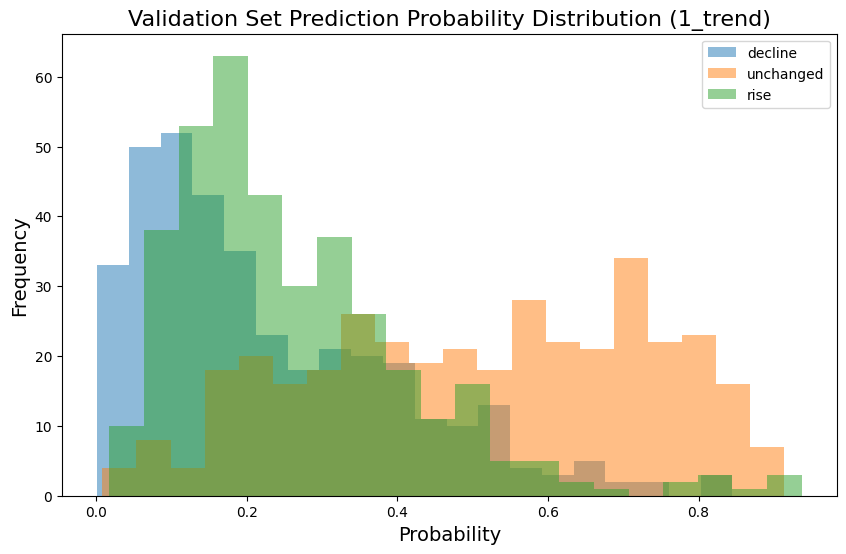

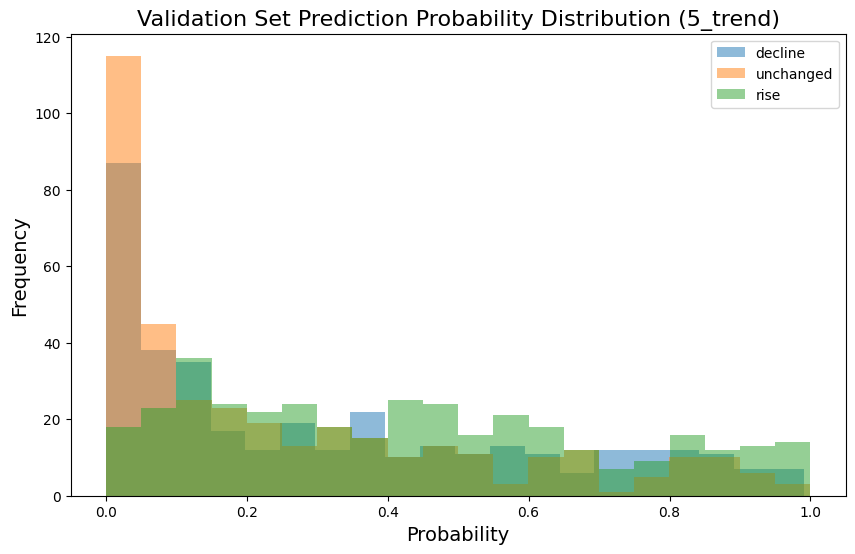

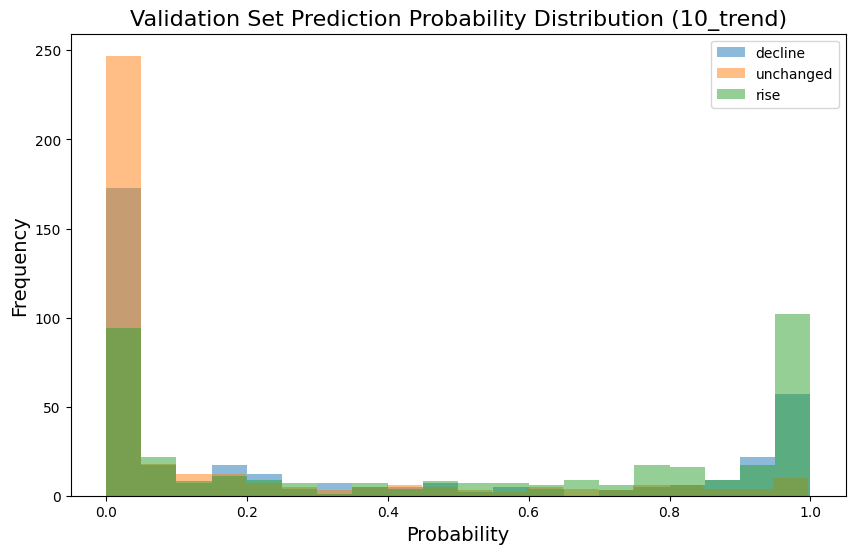

In [97]:
# 繪製驗證集的預測概率分佈圖
class_map = {0: "decline", 1: "unchanged", 2: "rise"}
class_order = [class_map[0], class_map[1], class_map[2]]

# 機率分布
probabilities_d1 = torch.softmax(mlp_1d.model(val_features_1d_mlp), dim=1).detach().numpy()
probabilities_d5 = torch.softmax(mlp_5d.model(val_features_5d_mlp), dim=1).detach().numpy()
probabilities_d10 = torch.softmax(mlp_10d.model(val_features_10d_mlp), dim=1).detach().numpy()

prob_dict = {label_trend[0]: probabilities_d1, 
             label_trend[1]: probabilities_d5,
             label_trend[2]: probabilities_d10,
            }

for key, value in prob_dict.items():
    # 繪製驗證集的機率分佈長條圖
    plt.figure(figsize=(10, 6))
    for i in range(value.shape[1]):
        plt.hist(value[:, i], bins=20, alpha=0.5, label=class_order[i])

    plt.title(f'Validation Set Prediction Probability Distribution ({key})', fontsize=16)
    plt.xlabel('Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.show()

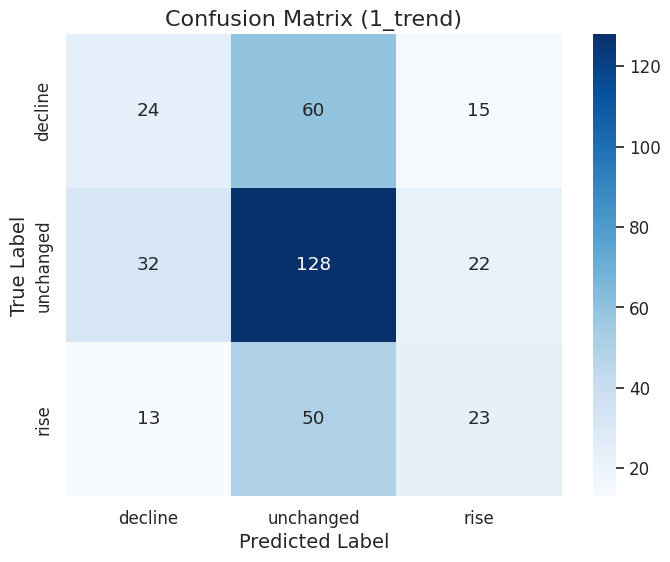

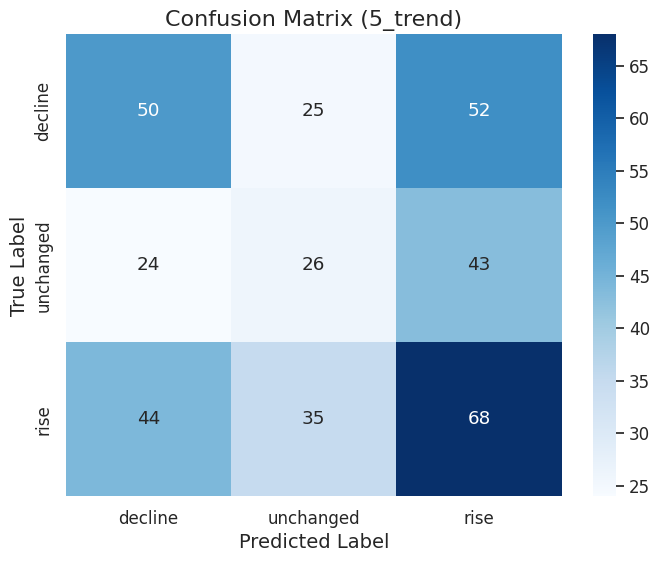

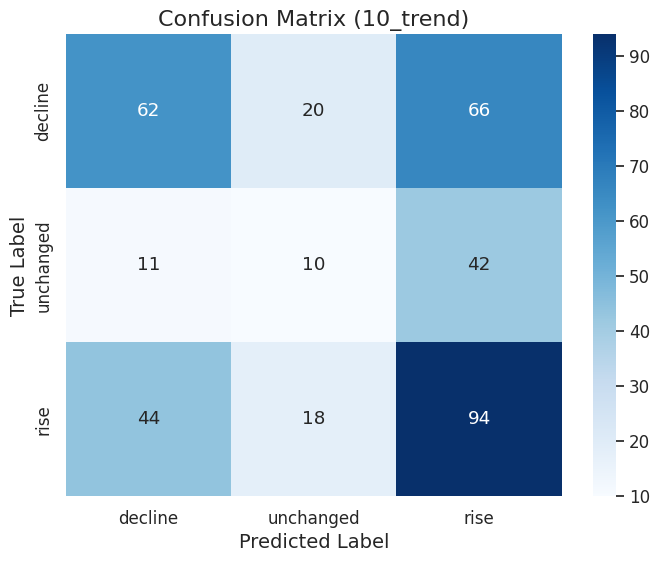

In [103]:
# 機率分布
pred_d1 = mlp_1d.predict(val_features_1d_mlp)
pred_d5 = mlp_5d.predict(val_features_5d_mlp)
pred_d10 = mlp_10d.predict(val_features_10d_mlp)

pred_dict = {label_trend[0]: [val_targets_1d_mlp, pred_d1], 
             label_trend[1]: [val_targets_5d_mlp, pred_d5],
             label_trend[2]: [val_targets_10d_mlp, pred_d10],
            }

# The code here draws 1 label(1_trend) chart
# Draw confusion_matrix
for key, value in pred_dict.items():
    cm = confusion_matrix(value[0][:], value[1][:])
    # 繪製混淆矩陣
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['decline', 'unchanged', 'rise'], yticklabels=['decline', 'unchanged', 'rise'])
    plt.title(f'Confusion Matrix ({key})', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()

## Testing

In [25]:
test_df = pd.read_csv("/kaggle/input/2024-artificial-intelligence-hw-1/test.csv")
test_df

,id,date,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
0,0,1,143.99,142.99,143.99,141.99,1369798,16.290696,212.093803,1.204988,...,0.134000,0.877460,144.782857,0.769936,3.528314,2.450388,2.00,-1.405847e+09,1.350707e+06,871331963.0
1,0,2,144.42,144.42,144.92,141.92,1196222,16.459398,200.424594,2.559340,...,0.131319,0.808490,144.854176,0.653656,3.490577,2.416963,3.00,-1.405050e+09,1.618916e+06,872528185.0
2,0,3,145.27,145.77,146.27,144.77,1221903,16.608715,205.594921,1.388990,...,0.203341,0.808490,145.425055,0.653656,3.373393,2.322154,1.85,-1.405457e+09,1.451868e+06,873750088.0
3,0,4,152.94,145.44,153.44,144.94,7824953,16.888389,178.143808,-0.724966,...,0.363319,3.294294,147.689890,10.852376,3.615324,2.363884,8.50,-1.397613e+09,3.646685e+06,882514490.0
4,0,5,149.53,151.53,155.03,148.53,4450101,17.143087,167.720081,-1.350238,...,0.461604,3.207036,148.822747,10.285080,3.821372,2.555589,6.50,-1.400694e+09,3.192448e+06,878064389.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,426,26,152.60,149.60,152.60,149.60,2019624,28.715604,208.685202,1.991429,...,-0.153802,2.108867,152.455055,4.447320,4.077149,2.671788,3.00,-1.396747e+09,-1.638342e+06,880974185.0
12806,426,27,154.86,155.36,155.86,154.36,1234617,28.910077,219.954123,-4.560006,...,-0.194593,2.570230,152.544835,6.606080,3.821623,2.467792,1.50,-1.395967e+09,-5.561426e+05,882761400.0
12807,426,28,154.41,152.41,155.41,151.41,1368270,30.321032,221.379706,-8.170982,...,-0.190066,1.908639,152.623077,3.642904,3.834364,2.483236,4.00,-1.395283e+09,-1.754569e+05,881393130.0
12808,426,29,156.21,155.71,158.21,154.71,1809694,31.793577,219.653663,-7.402138,...,-0.136835,1.162986,153.195165,1.352536,3.831910,2.453050,3.80,-1.395541e+09,-8.603005e+04,883202824.0


In [26]:
def create_test_features(df, days=day_period):
    
    features = []
    for i in range(days-1, len(df)+1, days):
        feature_row = []

        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])

        features.append(feature_row)
    
    return np.array(features)

test_features = create_test_features(test_df, days=30)

### 因為前面pytorch架構的問題，只能是>=0的數，所以這裡要再變回來

In [29]:
standard_feature = scaler.transform(test_features)

mlp_features = torch.from_numpy(standard_feature).float()

predictions_1d = mlp_1d.predict(mlp_features)-1
predictions_5d = mlp_5d.predict(mlp_features)-1
predictions_10d = mlp_10d.predict(mlp_features)-1

### 將資料儲存為CSV檔

In [ ]:
result = np.concatenate((predictions_1d, predictions_5d, predictions_10d))
# generate index
ids = range(len(result))
# build DataFrame
df = pd.DataFrame({
    'id': ids,
    'trend': result
})

In [645]:
# Save as CSV file
df.to_csv('predictions.csv', index=False)